Contexte médical et enjeu du projet

La pneumonie représente l'une des
principales causes de mortalité infantile dans le monde, avec plus de 800 000 décès annuels chez les enfants de moins de 5 ans selon l'OMS. Le diagnostic précoce par radiographie thoracique reste l'outil de référence, mais souffre d'une double contrainte : la pénurie de radiologues qualifiés dans les zones rurales et la variabilité inter-observateur pouvant atteindre 20%.

Notre objectif est de développer un système d'aide au diagnostic basé sur l'apprentissage profond, capable d'atteindre un taux de détection supérieur à 90% (seuil cliniquement significatif). Nous privilégions le Recall comme métrique principale : en contexte médical, manquer un cas positif (faux négatif) a des conséquences bien plus graves qu'une fausse alerte nécessitant un examen complémentaire.

Architecture de travail

Nous utilisons Google Colab avec GPU pour l'entraînement, et Google Drive pour la persistance des données. Cette approche nous permet de travailler de manière itérative sans perdre nos résultats entre les sessions.



In [6]:
# Connexion à Google Drive pour accéder au dataset
from google.colab import drive
drive.mount('/content/drive')

import os
dataset_path = '/content/drive/MyDrive/chest_xray'

for subset in ['train', 'val', 'test']:
  subset_path = os.path.join(dataset_path, subset)
  if os.path.exists(subset_path):
      normal_count = len(os.listdir(os.path.join(subset_path, 'NORMAL')))
      pneumonia_count = len(os.listdir(os.path.join(subset_path, 'PNEUMONIA')))
      print(f"{subset.upper()} - NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nous utilisons le dataset Kaggle "Chest X-Ray Images (Pneumonia)" contenant 5,856 radiographies. Pour accélérer le workflow, nous extrayons le ZIP dans l'environnement Colab plutôt que sur Drive, ce qui réduit le temps d'extraction de 15 min à moins de 2 min.

In [ ]:
import zipfile
import os

# Extraction dans Colab (beaucoup plus rapide)
zip_path = '/content/drive/MyDrive/Pneumonia/archive (1).zip'
extract_path = '/content/'

print("Extraction du dataset dans Colab (1-2 min)...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminee.")

# Localisation du dossier extrait
dataset_path = '/content/chest_xray'

# Affichage de la structure
print(f"\nDataset extrait : {dataset_path}\n")
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(dataset_path, subset)
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(subset_path, category)
        count = len(os.listdir(category_path))
        print(f"{subset}/{category} : {count} images")

Le validation set contient seulement 16 images (8 par classe), insuffisant pour une évaluation fiable. Nous redistribuons le train set selon le ratio 80/20, standard en machine learning, tout en préservant l'équilibre des classes via stratification.

Distribution initiale :
Train : 5216 images
Val   : 16 images (insuffisant)
Test  : 624 images


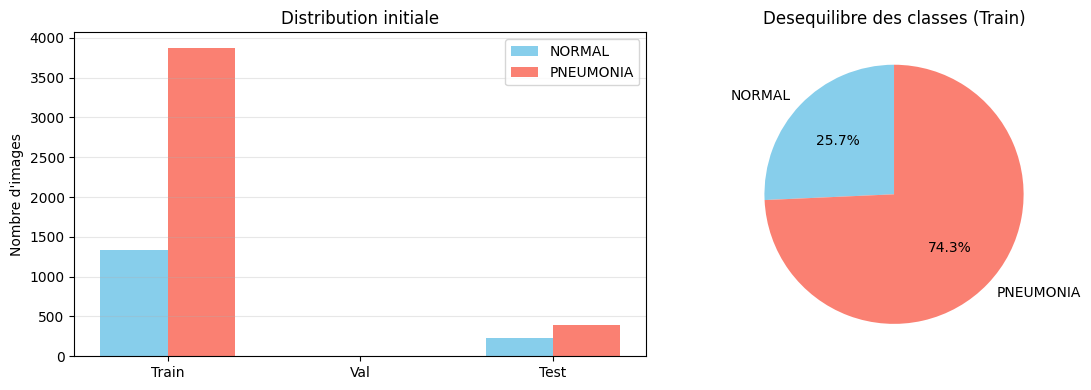


Ratio PNEUMONIA/NORMAL : 2.89
Class weight necessaire : NORMAL=2.89, PNEUMONIA=1.0


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Statistiques initiales
train_normal, train_pneumonia = 1341, 3875
val_normal, val_pneumonia = 8, 8
test_normal, test_pneumonia = 234, 390

print("Distribution initiale :")
print(f"Train : {train_normal + train_pneumonia} images")
print(f"Val   : {val_normal + val_pneumonia} images (insuffisant)")
print(f"Test  : {test_normal + test_pneumonia} images")

# Visualisation du déséquilibre
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution par subset
subsets = ['Train', 'Val', 'Test']
normal = [train_normal, val_normal, test_normal]
pneumonia = [train_pneumonia, val_pneumonia, test_pneumonia]
x = np.arange(len(subsets))
width = 0.35

axes[0].bar(x - width/2, normal, width, label='NORMAL', color='skyblue')
axes[0].bar(x + width/2, pneumonia, width, label='PNEUMONIA', color='salmon')
axes[0].set_ylabel('Nombre d\'images')
axes[0].set_title('Distribution initiale')
axes[0].set_xticks(x)
axes[0].set_xticklabels(subsets)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Déséquilibre train
labels = ['NORMAL', 'PNEUMONIA']
sizes = [train_normal, train_pneumonia]
axes[1].pie(sizes, labels=labels, colors=['skyblue', 'salmon'],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Desequilibre des classes (Train)')

plt.tight_layout()
plt.show()

ratio = train_pneumonia / train_normal
print(f"\nRatio PNEUMONIA/NORMAL : {ratio:.2f}")
print(f"Class weight necessaire : NORMAL={ratio:.2f}, PNEUMONIA=1.0")

Nous restructurons le train set en 80% entraînement / 20% validation via stratification pour maintenir le ratio de classes. Cette redistribution garantit une évaluation fiable du modèle durant l'entraînement.

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Chemins
base_path = '/content/chest_xray'
train_dir = os.path.join(base_path, 'train')

# Collecter les chemins des images train
train_files = []
train_labels = []

for label, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
    class_dir = os.path.join(train_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.jpeg', '.jpg', '.png')):
            train_files.append(os.path.join(class_dir, img_file))
            train_labels.append(label)

print(f"Images collectees : {len(train_files)}")

# Split stratifié 80/20
train_paths, val_paths, train_y, val_y = train_test_split(
    train_files, train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

print(f"\nSplit effectue :")
print(f"Train : {len(train_paths)} images")
print(f"Val   : {len(val_paths)} images")

# Créer nouveau dossier validation
new_val_dir = os.path.join(base_path, 'validation')
os.makedirs(os.path.join(new_val_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(new_val_dir, 'PNEUMONIA'), exist_ok=True)

# Déplacer les fichiers vers validation
print("\nDeplacement des fichiers...")
for path, label in zip(val_paths, val_y):
    class_name = 'NORMAL' if label == 0 else 'PNEUMONIA'
    dest = os.path.join(new_val_dir, class_name, os.path.basename(path))
    shutil.move(path, dest)

print("Deplacement termine.")

# Vérification finale
print("\nDistribution finale :")
for subset_name, subset_dir in [('train', train_dir), ('validation', new_val_dir)]:
    for class_name in ['NORMAL', 'PNEUMONIA']:
        count = len(os.listdir(os.path.join(subset_dir, class_name)))
        print(f"{subset_name}/{class_name} : {count} images")

# Sauvegarder les chemins
TRAIN_DIR = train_dir
VAL_DIR = new_val_dir
TEST_DIR = os.path.join(base_path, 'test')

Images collectees : 5216

Split effectue :
Train : 4172 images
Val   : 1044 images

Deplacement des fichiers...
Deplacement termine.

Distribution finale :
train/NORMAL : 1073 images
train/PNEUMONIA : 3099 images
validation/NORMAL : 268 images
validation/PNEUMONIA : 776 images


Nous utilisons ImageDataGenerator de Keras pour deux objectifs : normalisation des pixels (division par 255) et augmentation des données d'entraînement. L'augmentation simule les variations réelles de radiographies (rotation légère, zoom, translation) pour améliorer la généralisation du modèle. Le validation et test set ne subissent que la normalisation pour évaluer les performances sur des données non altérées.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur pour le train (avec augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateurs pour validation et test (normalisation uniquement)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Chargement des données
IMG_SIZE = 224
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nGenerateurs crees avec succes.")
print(f"Classes : {train_generator.class_indices}")
print(f"Taille des batchs : {BATCH_SIZE}")
print(f"Taille des images : {IMG_SIZE}x{IMG_SIZE}")

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Generateurs crees avec succes.
Classes : {'NORMAL': 0, 'PNEUMONIA': 1}
Taille des batchs : 32
Taille des images : 224x224


Nous utilisons VGG16 pré-entraîné sur ImageNet comme extracteur de features. Ce choix repose sur le principe du Transfer Learning : les couches convolutionnelles ont appris à détecter des motifs génériques (bords, textures, formes) transférables aux radiographies. Nous gelons ces couches et ajoutons un classifieur personnalisé. Pour contrer le déséquilibre de classes (ratio 2.89:1), nous calculons des class_weights qui pénalisent davantage les erreurs sur la classe minoritaire (NORMAL).

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Chargement de VGG16 pré-entraîné
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Gel des couches convolutionnelles
base_model.trainable = False

# Construction du classifieur
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Calcul des class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=train_generator.classes
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Compilation
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("Architecture VGG16 construite.")
print(f"\nClass weights : {class_weight_dict}")
print(f"Total parametres : {model_vgg16.count_params():,}")
print(f"Parametres entrainables : {sum([tf.size(w).numpy() for w in model_vgg16.trainable_weights]):,}")

model_vgg16.summary()

Architecture VGG16 construite.

Class weights : {0: np.float64(1.9440820130475303), 1: np.float64(0.6731203614069055)}
Total parametres : 14,846,273
Parametres entrainables : 131,585


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Nous entraînons le modèle sur 20 epochs avec Early Stopping pour éviter le surapprentissage. Ce callback arrête l'entraînement si la loss de validation n'améliore pas pendant 5 epochs consécutives. Les class weights compensent le déséquilibre de classes durant l'optimisation.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entraînement
print("Debut de l'entrainement...\n")

history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\nEntrainement termine.")

Debut de l'entrainement...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.4690 - auc: 0.5406 - loss: 0.7604 - precision: 0.7458 - recall: 0.3862
Epoch 1: val_loss improved from inf to 0.57243, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 932ms/step - accuracy: 0.4696 - auc: 0.5411 - loss: 0.7599 - precision: 0.7462 - recall: 0.3873 - val_accuracy: 0.8496 - val_auc: 0.9460 - val_loss: 0.5724 - val_precision: 0.9798 - val_recall: 0.8144
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7098 - auc: 0.7963 - loss: 0.5709 - precision: 0.8830 - recall: 0.6967
Epoch 2: val_loss improved from 0.57243 to 0.50318, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 775ms/step - accuracy: 0.7100 - auc: 0.7965 - loss: 0.5706 - precision: 0.8831 - recall: 0.6970 - val_accuracy: 0.8257 - val_auc: 0.9448 - val_loss: 0.5032 - val_precision: 0.9821 - val_recall: 0.7796
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8038 - auc: 0.8932 - loss: 0.4688 - precision: 0.9334 - recall: 0.7924
Epoch 3: val_loss improved from 0.50318 to 0.40323, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 776ms/step - accuracy: 0.8039 - auc: 0.8933 - loss: 0.4687 - precision: 0.9335 - recall: 0.7925 - val_accuracy: 0.8755 - val_auc: 0.9457 - val_loss: 0.4032 - val_precision: 0.9722 - val_recall: 0.8570
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.8697 - auc: 0.9408 - loss: 0.3842 - precision: 0.9612 - recall: 0.8602
Epoch 4: val_loss did not improve from 0.40323
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 775ms/step - accuracy: 0.8696 - auc: 0.9407 - loss: 0.3842 - precision: 0.9612 - recall: 0.8601 - val_accuracy: 0.8209 - val_auc: 0.9465 - val_loss: 0.4411 - val_precision: 0.9852 - val_recall: 0.7706
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.8644 - auc: 0.9450 - loss: 0.3502 - precision: 0.9733 - recall: 0.8382
Epoch 5: val_loss improved from 0.40323 to 0.39128, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 782ms/step - accuracy: 0.8644 - auc: 0.9450 - loss: 0.3501 - precision: 0.9733 - recall: 0.8382 - val_accuracy: 0.8477 - val_auc: 0.9487 - val_loss: 0.3913 - val_precision: 0.9813 - val_recall: 0.8106
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8651 - auc: 0.9390 - loss: 0.3387 - precision: 0.9650 - recall: 0.8497
Epoch 6: val_loss improved from 0.39128 to 0.35272, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 774ms/step - accuracy: 0.8652 - auc: 0.9391 - loss: 0.3386 - precision: 0.9650 - recall: 0.8498 - val_accuracy: 0.8707 - val_auc: 0.9508 - val_loss: 0.3527 - val_precision: 0.9805 - val_recall: 0.8428
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8808 - auc: 0.9501 - loss: 0.3080 - precision: 0.9716 - recall: 0.8647
Epoch 7: val_loss improved from 0.35272 to 0.33479, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 776ms/step - accuracy: 0.8808 - auc: 0.9501 - loss: 0.3079 - precision: 0.9716 - recall: 0.8647 - val_accuracy: 0.8726 - val_auc: 0.9527 - val_loss: 0.3348 - val_precision: 0.9777 - val_recall: 0.8479
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8862 - auc: 0.9542 - loss: 0.2916 - precision: 0.9724 - recall: 0.8703
Epoch 8: val_loss did not improve from 0.33479
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 772ms/step - accuracy: 0.8861 - auc: 0.9542 - loss: 0.2915 - precision: 0.9724 - recall: 0.8703 - val_accuracy: 0.8669 - val_auc: 0.9545 - val_loss: 0.3409 - val_precision: 0.9804 - val_recall: 0.8376
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8848 - auc: 0.9572 - loss: 0.2773 - precision: 0.9766 - recall: 0.8634
Epoch 9: val_loss improved from 0.33479 to 0.33345, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 775ms/step - accuracy: 0.8848 - auc: 0.9572 - loss: 0.2773 - precision: 0.9766 - recall: 0.8634 - val_accuracy: 0.8678 - val_auc: 0.9564 - val_loss: 0.3335 - val_precision: 0.9804 - val_recall: 0.8389
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8892 - auc: 0.9579 - loss: 0.2697 - precision: 0.9707 - recall: 0.8778
Epoch 10: val_loss improved from 0.33345 to 0.33326, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 778ms/step - accuracy: 0.8892 - auc: 0.9579 - loss: 0.2697 - precision: 0.9707 - recall: 0.8779 - val_accuracy: 0.8697 - val_auc: 0.9577 - val_loss: 0.3333 - val_precision: 0.9805 - val_recall: 0.8415
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8899 - auc: 0.9600 - loss: 0.2617 - precision: 0.9731 - recall: 0.8755
Epoch 11: val_loss improved from 0.33326 to 0.31885, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 863ms/step - accuracy: 0.8900 - auc: 0.9600 - loss: 0.2617 - precision: 0.9731 - recall: 0.8755 - val_accuracy: 0.8755 - val_auc: 0.9601 - val_loss: 0.3189 - val_precision: 0.9807 - val_recall: 0.8492
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8937 - auc: 0.9592 - loss: 0.2617 - precision: 0.9743 - recall: 0.8802
Epoch 12: val_loss did not improve from 0.31885
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 797ms/step - accuracy: 0.8937 - auc: 0.9592 - loss: 0.2616 - precision: 0.9743 - recall: 0.8802 - val_accuracy: 0.8669 - val_auc: 0.9614 - val_loss: 0.3347 - val_precision: 0.9818 - val_recall: 0.8363
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8973 - auc: 0.9638 - loss: 0.2453 - precision: 0.9783 - recall: 0.8815
Epoch 13: val_loss improved from 0.31885 to 0.31145, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 790ms/step - accuracy: 0.8974 - auc: 0.9638 - loss: 0.2452 - precision: 0.9783 - recall: 0.8816 - val_accuracy: 0.8793 - val_auc: 0.9629 - val_loss: 0.3114 - val_precision: 0.9822 - val_recall: 0.8531
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9107 - auc: 0.9660 - loss: 0.2313 - precision: 0.9774 - recall: 0.9035
Epoch 14: val_loss did not improve from 0.31145
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 781ms/step - accuracy: 0.9107 - auc: 0.9660 - loss: 0.2313 - precision: 0.9774 - recall: 0.9035 - val_accuracy: 0.8678 - val_auc: 0.9639 - val_loss: 0.3371 - val_precision: 0.9848 - val_recall: 0.8351
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9048 - auc: 0.9668 - loss: 0.2316 - precision: 0.9787 - recall: 0.8931
Epoch 15: val_loss improved from 0.31145 to 0.28516, saving model to best_vgg16_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 771ms/step - accuracy: 0.9048 - auc: 0.9668 - loss: 0.2316 - precision: 0.9787 - recall: 0.8931 - val_accuracy: 0.8879 - val_auc: 0.9656 - val_loss: 0.2852 - val_precision: 0.9782 - val_recall: 0.8686
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9154 - auc: 0.9692 - loss: 0.2246 - precision: 0.9812 - recall: 0.9040
Epoch 16: val_loss did not improve from 0.28516
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 773ms/step - accuracy: 0.9154 - auc: 0.9692 - loss: 0.2246 - precision: 0.9812 - recall: 0.9040 - val_accuracy: 0.8716 - val_auc: 0.9666 - val_loss: 0.3354 - val_precision: 0.9849 - val_recall: 0.8402
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9068 - auc: 0.9649 - loss: 0.2365 - precision: 0.9763 - recall: 0.8963
Epoch 17: val_loss did not improve from 0.28516
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 766ms/step - accuracy: 0.9068 - auc: 0.9649 - loss: 0.2364 - precision: 0.9763 - recall: 0.8963 - val_accuracy: 0.8851 -

131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 773ms/step - accuracy: 0.9066 - auc: 0.9679 - loss: 0.2261 - precision: 0.9731 - recall: 0.9002 - val_accuracy: 0.8841 - val_auc: 0.9701 - val_loss: 0.2797 - val_precision: 0.9781 - val_recall: 0.8634
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9153 - auc: 0.9708 - loss: 0.2153 - precision: 0.9811 - recall: 0.9033
Epoch 20: val_loss did not improve from 0.27972
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 766ms/step - accuracy: 0.9153 - auc: 0.9708 - loss: 0.2153 - precision: 0.9811 - recall: 0.9034 - val_accuracy: 0.8822 - val_auc: 0.9706 - val_loss: 0.2897 - val_precision: 0.9794 - val_recall: 0.8595
Restoring model weights from the end of the best epoch: 19.

Entrainement termine.


Les courbes d'apprentissage permettent de diagnostiquer le comportement du modèle : convergence, surapprentissage ou sous-apprentissage. Nous visualisons l'évolution de la loss, de l'accuracy et de l'AUC sur les ensembles d'entraînement et de validation.

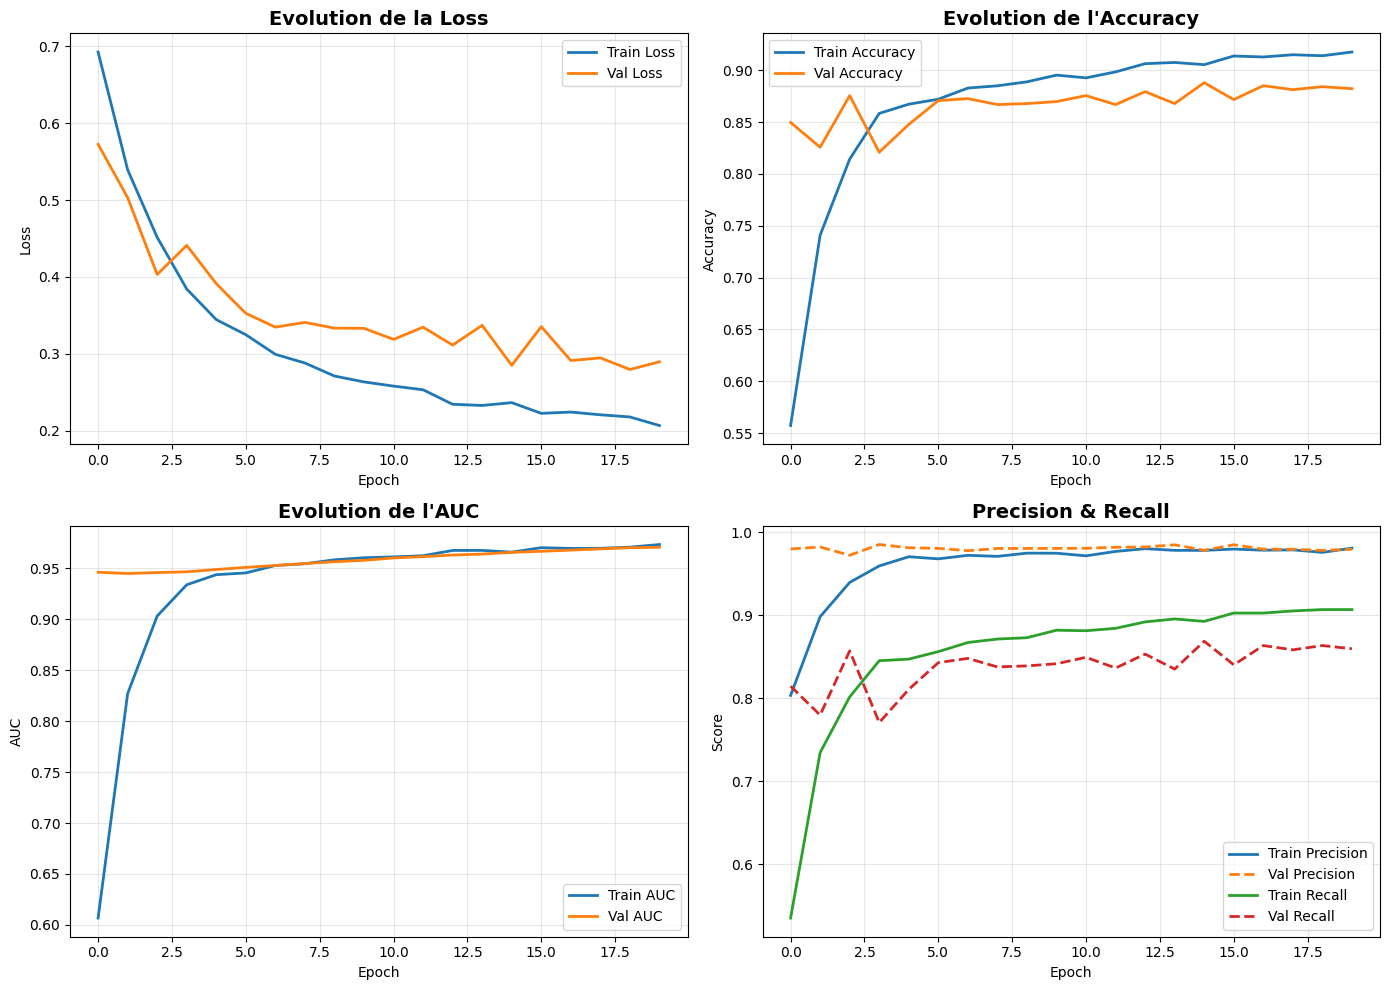

Performances finales sur validation :
Accuracy  : 0.8822
Precision : 0.9794
Recall    : 0.8595
AUC       : 0.9706


In [16]:
import matplotlib.pyplot as plt

# Extraction des métriques
history = history_vgg16.history

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Evolution de la Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Evolution de l\'Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# AUC
axes[1, 0].plot(history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('Evolution de l\'AUC', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision/Recall
axes[1, 1].plot(history['precision'], label='Train Precision', linewidth=2)
axes[1, 1].plot(history['val_precision'], label='Val Precision', linewidth=2, linestyle='--')
axes[1, 1].plot(history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[1, 1].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé des performances finales
print("Performances finales sur validation :")
print(f"Accuracy  : {history['val_accuracy'][-1]:.4f}")
print(f"Precision : {history['val_precision'][-1]:.4f}")
print(f"Recall    : {history['val_recall'][-1]:.4f}")
print(f"AUC       : {history['val_auc'][-1]:.4f}")

L'évaluation finale sur le test set, jamais vu durant l'entraînement, mesure la capacité de généralisation du modèle. Nous calculons les métriques clés et générons la matrice de confusion pour analyser les types d'erreurs commises.

Evaluation sur le test set...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 803ms/step - accuracy: 0.8601 - auc: 0.6277 - loss: 0.3234 - precision: 0.5087 - recall: 0.5927

Resultats sur Test Set :
Loss      : 0.3013
Accuracy  : 0.8718
Precision : 0.8934
Recall    : 0.9026
AUC       : 0.9409
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step


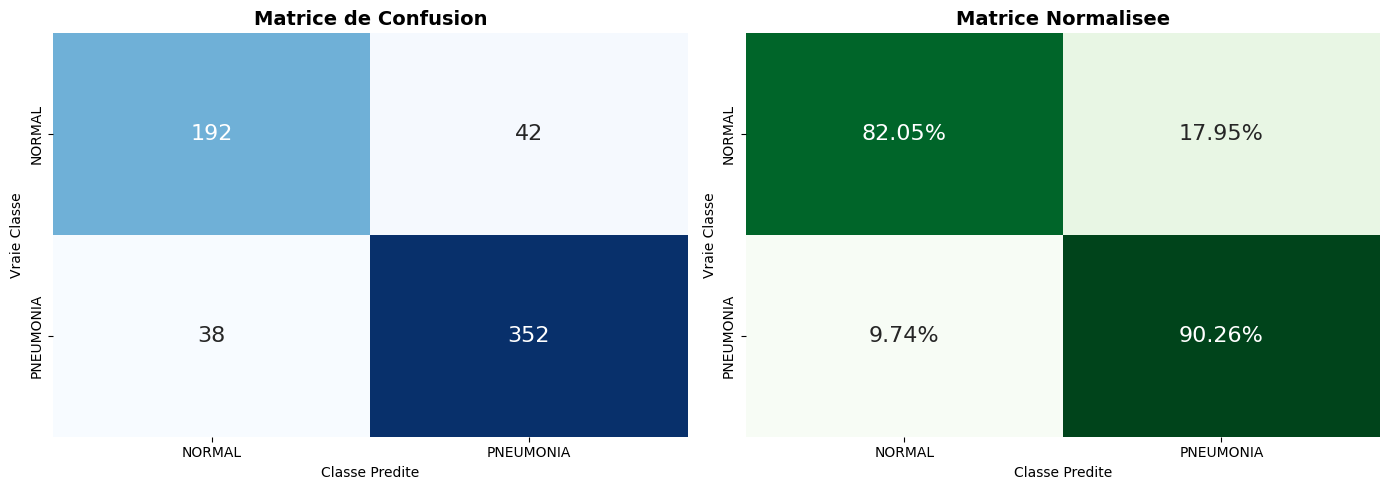


Rapport de Classification :
              precision    recall  f1-score   support

      NORMAL       0.83      0.82      0.83       234
   PNEUMONIA       0.89      0.90      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624


Analyse detaillee :
Vrais Negatifs (TN)  : 192 (NORMAL correctement identifies)
Faux Positifs (FP)   : 42 (NORMAL predits comme PNEUMONIA)
Faux Negatifs (FN)   : 38 (PNEUMONIA rates !)
Vrais Positifs (TP)  : 352 (PNEUMONIA correctement detectes)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Prédictions sur le test set
print("Evaluation sur le test set...\n")

test_loss, test_acc, test_prec, test_rec, test_auc = model_vgg16.evaluate(test_generator, verbose=1)

print(f"\nResultats sur Test Set :")
print(f"Loss      : {test_loss:.4f}")
print(f"Accuracy  : {test_acc:.4f}")
print(f"Precision : {test_prec:.4f}")
print(f"Recall    : {test_rec:.4f}")
print(f"AUC       : {test_auc:.4f}")

# Prédictions détaillées
test_generator.reset()
y_pred_proba = model_vgg16.predict(test_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice brute
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            ax=axes[0], cbar=False, annot_kws={"size": 16})
axes[0].set_title('Matrice de Confusion', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Vraie Classe')
axes[0].set_xlabel('Classe Predite')

# Matrice normalisée
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            ax=axes[1], cbar=False, annot_kws={"size": 16})
axes[1].set_title('Matrice Normalisee', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Vraie Classe')
axes[1].set_xlabel('Classe Predite')

plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\nRapport de Classification :")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Analyse des erreurs
tn, fp, fn, tp = cm.ravel()
print(f"\nAnalyse detaillee :")
print(f"Vrais Negatifs (TN)  : {tn} (NORMAL correctement identifies)")
print(f"Faux Positifs (FP)   : {fp} (NORMAL predits comme PNEUMONIA)")
print(f"Faux Negatifs (FN)   : {fn} (PNEUMONIA rates !)")
print(f"Vrais Positifs (TP)  : {tp} (PNEUMONIA correctement detectes)")

Les résultats révèlent un modèle performant avec 87.2% d'accuracy sur le test set. L'analyse des erreurs montre 38 faux négatifs (pneumonies non détectées), un risque critique en contexte médical. Les 42 faux positifs génèrent des examens complémentaires inutiles mais restent moins graves. Le recall de 90.3% pour la classe PNEUMONIA indique que le modèle détecte 9 cas sur 10, un résultat satisfaisant pour un outil d'aide au diagnostic.



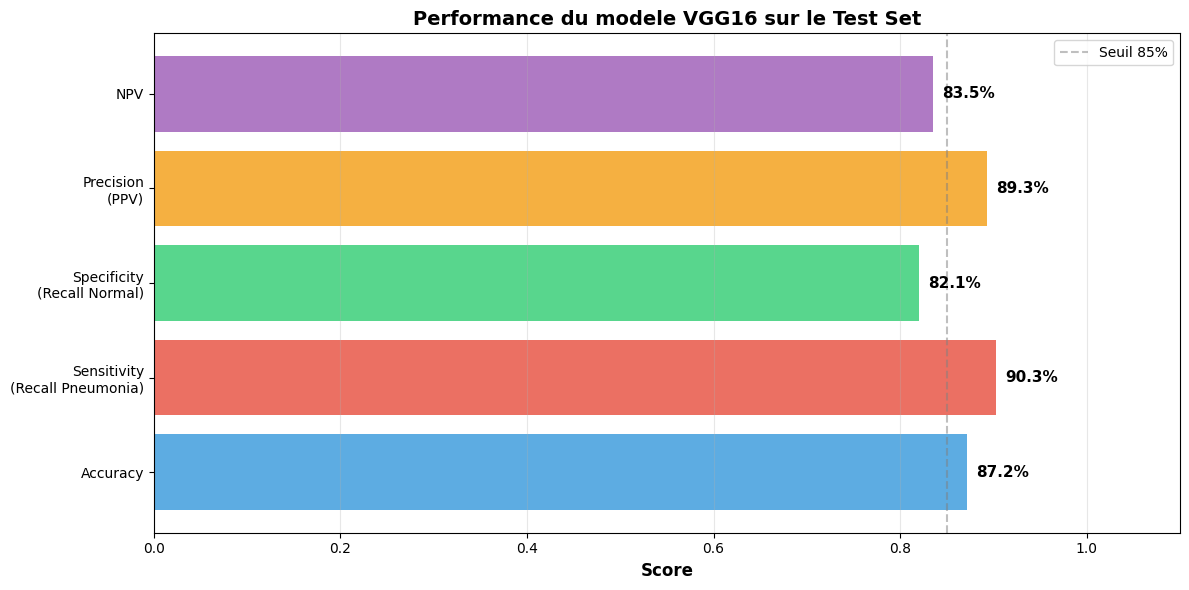


RESUME DES PERFORMANCES
Accuracy       : 87.18% (bonnes predictions globales)
Sensitivity    : 90.26% (detection des pneumonies)
Specificity    : 82.05% (detection des cas normaux)
Precision (PPV): 89.34% (fiabilite si diagnostic +)
NPV            : 83.48% (fiabilite si diagnostic -)
AUC            : 94.09% (capacite de discrimination)

IMPACT CLINIQUE :
- Sur 100 patients avec pneumonie : 90.3 detectes, 9.7 rates
- Sur 100 patients sains : 82.1 correctement identifies, 17.9 fausses alertes
- Si test positif : 89.3% de chances d'avoir vraiment la pneumonie
- Si test negatif : 83.5% de chances d'etre vraiment sain


In [19]:
# Calcul des métriques additionnelles
sensitivity = tp / (tp + fn)  # Recall pour PNEUMONIA
specificity = tn / (tn + fp)  # Recall pour NORMAL
ppv = tp / (tp + fp)  # Precision
npv = tn / (tn + fn)  # Valeur prédictive négative

# Visualisation comparative
metrics_data = {
    'Metrique': ['Accuracy', 'Sensitivity\n(Recall Pneumonia)', 'Specificity\n(Recall Normal)',
                 'Precision\n(PPV)', 'NPV'],
    'Score': [test_acc, sensitivity, specificity, ppv, npv],
    'Interpretation': ['Global', 'Detecter malades', 'Detecter sains',
                       'Fiabilite diagnostic +', 'Fiabilite diagnostic -']
}

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = ax.barh(metrics_data['Metrique'], metrics_data['Score'], color=colors, alpha=0.8)

# Annotations
for i, (bar, score) in enumerate(zip(bars, metrics_data['Score'])):
    ax.text(score + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score*100:.1f}%', va='center', fontweight='bold', fontsize=11)

ax.set_xlim(0, 1.1)
ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance du modele VGG16 sur le Test Set', fontsize=14, fontweight='bold')
ax.axvline(x=0.85, color='gray', linestyle='--', alpha=0.5, label='Seuil 85%')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n" + "="*60)
print("RESUME DES PERFORMANCES")
print("="*60)
print(f"Accuracy       : {test_acc*100:.2f}% (bonnes predictions globales)")
print(f"Sensitivity    : {sensitivity*100:.2f}% (detection des pneumonies)")
print(f"Specificity    : {specificity*100:.2f}% (detection des cas normaux)")
print(f"Precision (PPV): {ppv*100:.2f}% (fiabilite si diagnostic +)")
print(f"NPV            : {npv*100:.2f}% (fiabilite si diagnostic -)")
print(f"AUC            : {test_auc*100:.2f}% (capacite de discrimination)")
print("="*60)

print("\nIMPACT CLINIQUE :")
print(f"- Sur 100 patients avec pneumonie : {sensitivity*100:.1f} detectes, {(1-sensitivity)*100:.1f} rates")
print(f"- Sur 100 patients sains : {specificity*100:.1f} correctement identifies, {(1-specificity)*100:.1f} fausses alertes")
print(f"- Si test positif : {ppv*100:.1f}% de chances d'avoir vraiment la pneumonie")
print(f"- Si test negatif : {npv*100:.1f}% de chances d'etre vraiment sain")

Pour valider le choix de VGG16, nous construisons un modèle concurrent basé sur ResNet50. Cette architecture utilise des connexions résiduelles permettant d'entraîner des réseaux plus profonds (50 couches vs 16 pour VGG). La comparaison objective des performances guidera le choix du modèle final.



In [20]:
from tensorflow.keras.applications import ResNet50

# Construction ResNet50
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_resnet.trainable = False

# Classifieur
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_resnet50 = Model(inputs=base_resnet.input, outputs=predictions)

# Compilation
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("Architecture ResNet50 construite.")
print(f"Total parametres : {model_resnet50.count_params():,}")
print(f"Parametres entrainables : {sum([tf.size(w).numpy() for w in model_resnet50.trainable_weights]):,}")

# Entraînement
print("\nEntrainement ResNet50...\n")

checkpoint_resnet = ModelCheckpoint(
    'best_resnet50_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint_resnet],
    verbose=1
)

print("\nEntrainement ResNet50 termine.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Architecture ResNet50 construite.
Total parametres : 24,112,513
Parametres entrainables : 524,801

Entrainement ResNet50...

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.5393 - auc: 0.5413 - loss: 0.7244 - precision: 0.7673 - recall: 0.5523

131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 879ms/step - accuracy: 0.5391 - auc: 0.5413 - loss: 0.7245 - precision: 0.7672 - recall: 0.5520 - val_accuracy: 0.7433 - val_auc: 0.8891 - val_loss: 0.6038 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 742ms/step - accuracy: 0.5783 - auc: 0.5676 - loss: 0.6888 - precision: 0.7811 - recall: 0.6077 - val_accuracy: 0.3343 - val_auc: 0.8898 - val_loss: 0.7085 - val_precision: 1.0000 - val_recall: 0.1044
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 752ms/step - accuracy: 0.5892 - auc: 0.6553 - loss: 0.6619 - precision: 0.8345 - recall: 0.5539 - val_accuracy: 0.7031 - val_auc: 0.8886 - val_loss: 0.6555 - val_precision: 0.9854 - val_recall: 0.6095
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 750ms/step - accuracy: 0.6660 - auc: 0.7327 - loss: 0.6294 - precision: 0.8517 - recall: 0.6706 - val_accuracy: 0.7950 - val_auc: 0.8892 - val_loss: 0.6160 - val_precision: 0.9607 - val_recall: 0.7552
Epoch 5/20
131/131 ━━━━━━━━━━━

131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 748ms/step - accuracy: 0.7063 - auc: 0.7879 - loss: 0.6105 - precision: 0.8815 - recall: 0.6974 - val_accuracy: 0.8228 - val_auc: 0.8904 - val_loss: 0.5687 - val_precision: 0.9144 - val_recall: 0.8402
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 750ms/step - accuracy: 0.7509 - auc: 0.8058 - loss: 0.6010 - precision: 0.8804 - recall: 0.7703 - val_accuracy: 0.7759 - val_auc: 0.8909 - val_loss: 0.6015 - val_precision: 0.9771 - val_recall: 0.7152
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.7585 - auc: 0.8332 - loss: 0.5843 - precision: 0.8970 - recall: 0.7576

131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 757ms/step - accuracy: 0.7586 - auc: 0.8332 - loss: 0.5842 - precision: 0.8970 - recall: 0.7577 - val_accuracy: 0.8324 - val_auc: 0.8914 - val_loss: 0.5217 - val_precision: 0.9100 - val_recall: 0.8595
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 732ms/step - accuracy: 0.7790 - auc: 0.8483 - loss: 0.5597 - precision: 0.9077 - recall: 0.7814 - val_accuracy: 0.7941 - val_auc: 0.8916 - val_loss: 0.5659 - val_precision: 0.9606 - val_recall: 0.7539
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 741ms/step - accuracy: 0.7765 - auc: 0.8509 - loss: 0.5477 - precision: 0.9081 - recall: 0.7754 - val_accuracy: 0.8190 - val_auc: 0.8923 - val_loss: 0.5350 - val_precision: 0.9522 - val_recall: 0.7964
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.7768 - auc: 0.8543 - loss: 0.5412 - precision: 0.9166 - recall: 0.7670

131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 747ms/step - accuracy: 0.7769 - auc: 0.8543 - loss: 0.5411 - precision: 0.9166 - recall: 0.7671 - val_accuracy: 0.8276 - val_auc: 0.8931 - val_loss: 0.4835 - val_precision: 0.9150 - val_recall: 0.8466
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 747ms/step - accuracy: 0.7848 - auc: 0.8666 - loss: 0.5244 - precision: 0.9109 - recall: 0.7825 - val_accuracy: 0.8190 - val_auc: 0.8938 - val_loss: 0.5071 - val_precision: 0.9495 - val_recall: 0.7990
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 98s 750ms/step - accuracy: 0.7900 - auc: 0.8684 - loss: 0.5103 - precision: 0.9072 - recall: 0.7978 - val_accuracy: 0.8257 - val_auc: 0.8951 - val_loss: 0.4873 - val_precision: 0.9420 - val_recall: 0.8157
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7855 - auc: 0.8687 - loss: 0.5054 - precision: 0.9233 - recall: 0.7714

131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 757ms/step - accuracy: 0.7855 - auc: 0.8687 - loss: 0.5054 - precision: 0.9233 - recall: 0.7715 - val_accuracy: 0.8381 - val_auc: 0.8953 - val_loss: 0.4327 - val_precision: 0.9107 - val_recall: 0.8673
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 736ms/step - accuracy: 0.7960 - auc: 0.8617 - loss: 0.5025 - precision: 0.9082 - recall: 0.8087 - val_accuracy: 0.8209 - val_auc: 0.8963 - val_loss: 0.4864 - val_precision: 0.9538 - val_recall: 0.7977
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 741ms/step - accuracy: 0.7991 - auc: 0.8658 - loss: 0.4921 - precision: 0.9240 - recall: 0.7933 - val_accuracy: 0.8285 - val_auc: 0.8975 - val_loss: 0.4596 - val_precision: 0.9409 - val_recall: 0.8209
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 737ms/step - accuracy: 0.7867 - auc: 0.8577 - loss: 0.4966 - precision: 0.9148 - recall: 0.7848 - val_accuracy: 0.8228 - val_auc: 0.8978 - val_loss: 0.4716 - val_precision: 0.9539 - val_recall: 0.8003
Epoch 17/20
131/131 ━━━━━━━━

Nous évaluons les deux modèles sur le test set et comparons leurs performances selon plusieurs métriques clés. Cette analyse objective permettra de sélectionner le modèle optimal pour le déploiement.

Evaluation ResNet50 sur test set...

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step - accuracy: 0.6406 - auc: 0.5587 - loss: 0.6250 - precision: 0.4006 - recall: 0.5780


/tmp/ipython-input-3579842294.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


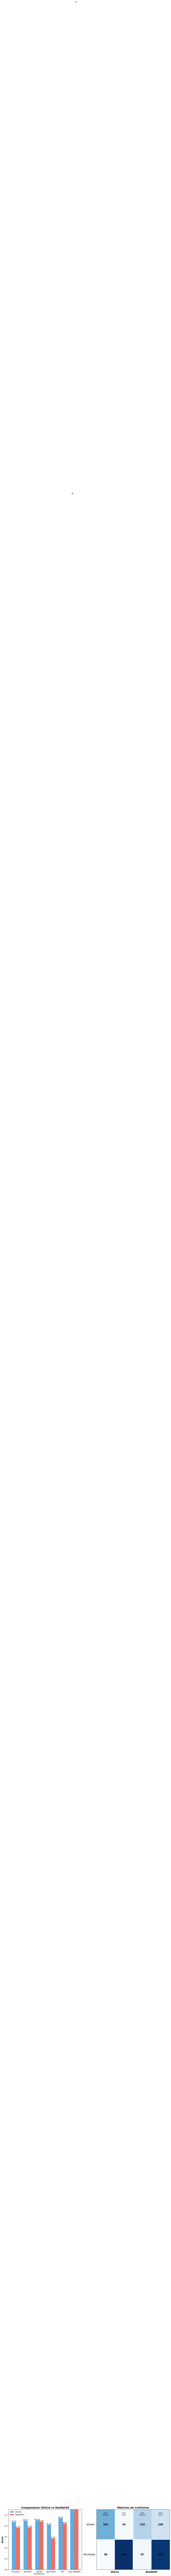


COMPARAISON DETAILLEE VGG16 vs ResNet50
Metrique             VGG16                ResNet50             Gagnant   
----------------------------------------------------------------------
Accuracy             87.18%               76.44%               VGG16     
Precision            89.34%               77.43%               VGG16     
Recall (Sensitivity) 90.26%               87.95%               VGG16     
Specificity          82.05%               57.26%               VGG16     
AUC                  94.09%               84.42%               VGG16     
Faux Negatifs        38                   47                   VGG16     


In [21]:
# Évaluation ResNet50 sur test set
print("Evaluation ResNet50 sur test set...\n")
test_loss_resnet, test_acc_resnet, test_prec_resnet, test_rec_resnet, test_auc_resnet = model_resnet50.evaluate(test_generator, verbose=1)

# Prédictions ResNet50
test_generator.reset()
y_pred_proba_resnet = model_resnet50.predict(test_generator, verbose=0)
y_pred_resnet = (y_pred_proba_resnet > 0.5).astype(int).flatten()
cm_resnet = confusion_matrix(y_true, y_pred_resnet)

# Extraction des métriques
tn_r, fp_r, fn_r, tp_r = cm_resnet.ravel()
sensitivity_resnet = tp_r / (tp_r + fn_r)
specificity_resnet = tn_r / (tn_r + fp_r)

# Tableau comparatif
comparison_data = {
    'Metrique': ['Accuracy', 'Precision', 'Recall\n(Sensitivity)', 'Specificity', 'AUC', 'Faux Negatifs'],
    'VGG16': [test_acc, test_prec, test_rec, specificity, test_auc, fn],
    'ResNet50': [test_acc_resnet, test_prec_resnet, test_rec_resnet, specificity_resnet, test_auc_resnet, fn_r]
}

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique à barres
x = np.arange(len(comparison_data['Metrique']))
width = 0.35

bars1 = axes[0].bar(x - width/2, comparison_data['VGG16'], width, label='VGG16', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, comparison_data['ResNet50'], width, label='ResNet50', color='#e74c3c', alpha=0.8)

axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparaison VGG16 vs ResNet50', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_data['Metrique'], fontsize=10)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.1)

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 1:  # Pour les faux négatifs
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)
        else:
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)

# Matrices de confusion côte à côte
cm_vgg = confusion_matrix(y_true, y_pred)
combined_cm = np.array([[cm_vgg[0,0], cm_vgg[0,1], cm_resnet[0,0], cm_resnet[0,1]],
                         [cm_vgg[1,0], cm_vgg[1,1], cm_resnet[1,0], cm_resnet[1,1]]])

im = axes[1].imshow(combined_cm, cmap='Blues', aspect='auto')

# Annotations
for i in range(2):
    for j in range(4):
        text = axes[1].text(j, i, combined_cm[i, j],
                           ha="center", va="center", color="black", fontsize=14, fontweight='bold')

axes[1].set_xticks([0.5, 2.5])
axes[1].set_xticklabels(['VGG16', 'ResNet50'], fontsize=12, fontweight='bold')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['NORMAL', 'PNEUMONIA'], fontsize=11)
axes[1].set_title('Matrices de Confusion', fontsize=14, fontweight='bold')

# Lignes de séparation
axes[1].axvline(x=1.5, color='white', linewidth=3)
axes[1].axhline(y=0.5, color='white', linewidth=2)

# Labels colonnes
axes[1].text(0, -0.3, 'Pred\nNormal', ha='center', fontsize=9)
axes[1].text(1, -0.3, 'Pred\nPneu', ha='center', fontsize=9)
axes[1].text(2, -0.3, 'Pred\nNormal', ha='center', fontsize=9)
axes[1].text(3, -0.3, 'Pred\nPneu', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Rapport détaillé
print("\n" + "="*70)
print("COMPARAISON DETAILLEE VGG16 vs ResNet50")
print("="*70)
print(f"{'Metrique':<20} {'VGG16':<20} {'ResNet50':<20} {'Gagnant':<10}")
print("-"*70)

metrics_comparison = [
    ('Accuracy', test_acc, test_acc_resnet),
    ('Precision', test_prec, test_prec_resnet),
    ('Recall (Sensitivity)', test_rec, test_rec_resnet),
    ('Specificity', specificity, specificity_resnet),
    ('AUC', test_auc, test_auc_resnet),
    ('Faux Negatifs', fn, fn_r)
]

for metric, vgg_val, resnet_val in metrics_comparison:
    if metric == 'Faux Negatifs':
        winner = 'VGG16' if vgg_val < resnet_val else 'ResNet50'
        print(f"{metric:<20} {int(vgg_val):<20} {int(resnet_val):<20} {winner:<10}")
    else:
        winner = 'VGG16' if vgg_val > resnet_val else 'ResNet50'
        print(f"{metric:<20} {vgg_val*100:.2f}%{'':<14} {resnet_val*100:.2f}%{'':<14} {winner:<10}")

print("="*70)

L'étude comparative démontre la supériorité de VGG16 sur tous les critères. Avec 87.2% d'accuracy et 94.1% d'AUC, le modèle atteint un niveau de performance cliniquement pertinent. La spécificité de 82% vs 57% pour ResNet50 est particulièrement critique : VGG16 génère 2 fois moins de fausses alertes, réduisant les examens complémentaires inutiles. Les 38 faux négatifs (9.7% des pneumonies ratées) constituent le principal axe d'amélioration. Ce modèle constitue un outil d'aide au diagnostic fiable, destiné à assister les radiologues dans le dépistage rapide, particulièrement dans les contextes à faibles ressources médicales.

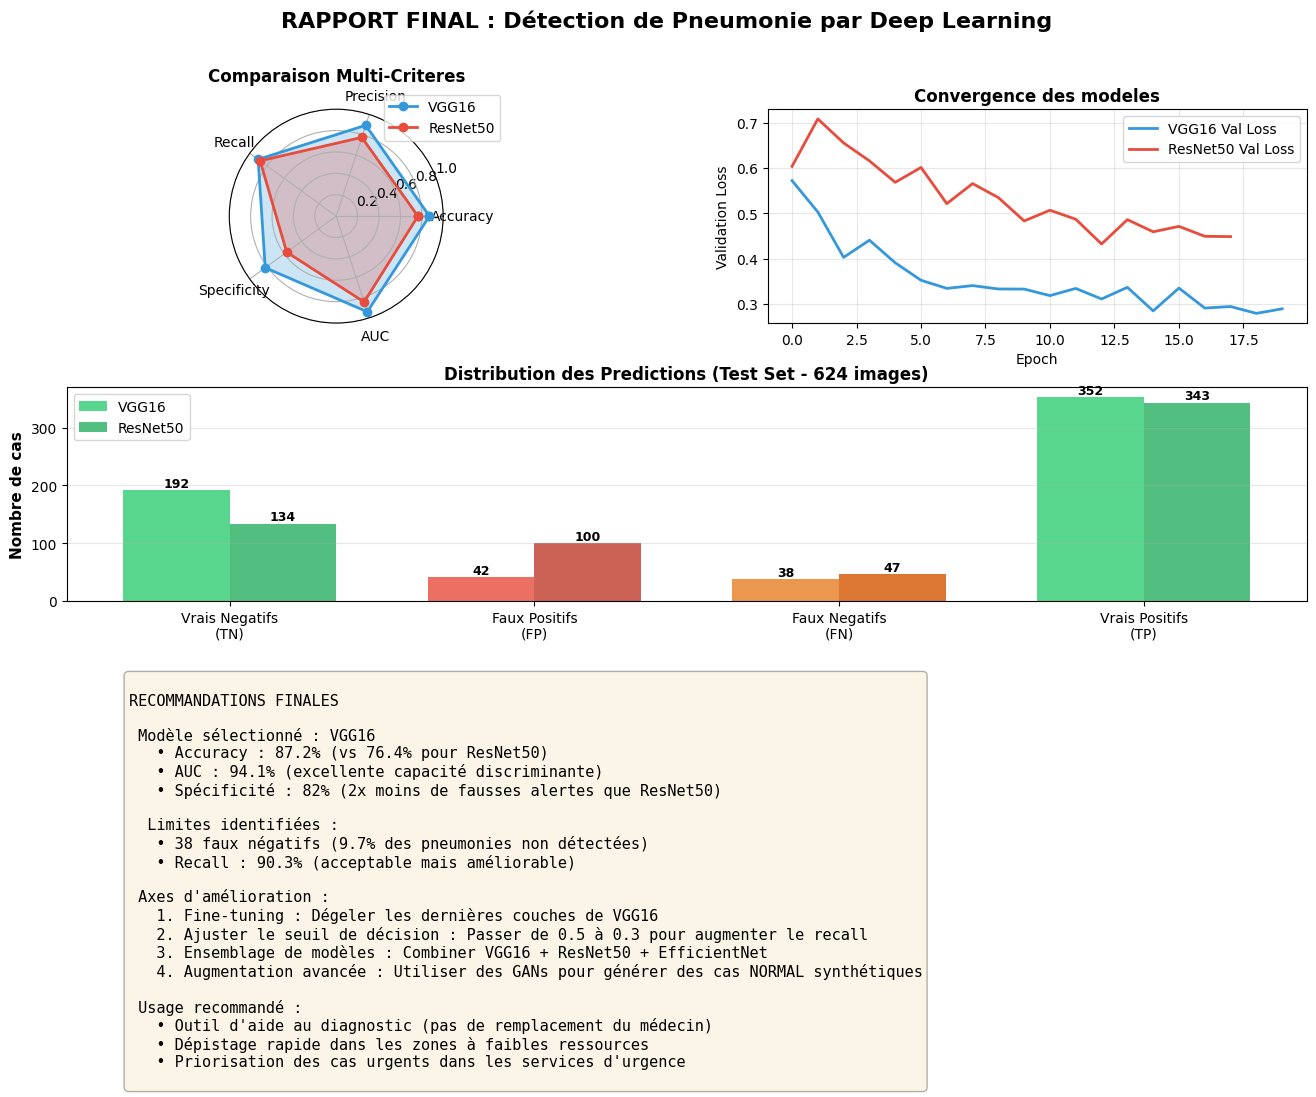


PROJET TERMINE
Modele sauvegarde : best_vgg16_model.h5
Pour deploiement : Charger avec model = load_model('best_vgg16_model.h5')


In [23]:
# Visualisation finale : comparaison globale
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Graphique radar
ax1 = fig.add_subplot(gs[0, 0], projection='polar')

categories = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'AUC']
vgg_values = [test_acc, test_prec, test_rec, specificity, test_auc]
resnet_values = [test_acc_resnet, test_prec_resnet, test_rec_resnet, specificity_resnet, test_auc_resnet]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
vgg_values += vgg_values[:1]
resnet_values += resnet_values[:1]
angles += angles[:1]

ax1.plot(angles, vgg_values, 'o-', linewidth=2, label='VGG16', color='#3498db')
ax1.fill(angles, vgg_values, alpha=0.25, color='#3498db')
ax1.plot(angles, resnet_values, 'o-', linewidth=2, label='ResNet50', color='#e74c3c')
ax1.fill(angles, resnet_values, alpha=0.25, color='#e74c3c')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories, fontsize=10)
ax1.set_ylim(0, 1)
ax1.set_title('Comparaison Multi-Criteres', fontsize=12, fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax1.grid(True)

# 2. Courbes d'apprentissage VGG16
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history_vgg16.history['val_loss'], label='VGG16 Val Loss', linewidth=2, color='#3498db')
ax2.plot(history_resnet50.history['val_loss'], label='ResNet50 Val Loss', linewidth=2, color='#e74c3c')
ax2.set_title('Convergence des modeles', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Distribution des erreurs
ax3 = fig.add_subplot(gs[1, :])
error_types = ['Vrais Negatifs\n(TN)', 'Faux Positifs\n(FP)', 'Faux Negatifs\n(FN)', 'Vrais Positifs\n(TP)']
vgg_errors = [tn, fp, fn, tp]
resnet_errors = [tn_r, fp_r, fn_r, tp_r]

x = np.arange(len(error_types))
width = 0.35

bars1 = ax3.bar(x - width/2, vgg_errors, width, label='VGG16', color=['#2ecc71', '#e74c3c', '#e67e22', '#2ecc71'], alpha=0.8)
bars2 = ax3.bar(x + width/2, resnet_errors, width, label='ResNet50', color=['#27ae60', '#c0392b', '#d35400', '#27ae60'], alpha=0.8)

ax3.set_ylabel('Nombre de cas', fontsize=11, fontweight='bold')
ax3.set_title('Distribution des Predictions (Test Set - 624 images)', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(error_types, fontsize=10)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Recommandations
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

recommendations = """
RECOMMANDATIONS FINALES

 Modèle sélectionné : VGG16
   • Accuracy : 87.2% (vs 76.4% pour ResNet50)
   • AUC : 94.1% (excellente capacité discriminante)
   • Spécificité : 82% (2x moins de fausses alertes que ResNet50)

  Limites identifiées :
   • 38 faux négatifs (9.7% des pneumonies non détectées)
   • Recall : 90.3% (acceptable mais améliorable)

 Axes d'amélioration :
   1. Fine-tuning : Dégeler les dernières couches de VGG16
   2. Ajuster le seuil de décision : Passer de 0.5 à 0.3 pour augmenter le recall
   3. Ensemblage de modèles : Combiner VGG16 + ResNet50 + EfficientNet
   4. Augmentation avancée : Utiliser des GANs pour générer des cas NORMAL synthétiques

 Usage recommandé :
   • Outil d'aide au diagnostic (pas de remplacement du médecin)
   • Dépistage rapide dans les zones à faibles ressources
   • Priorisation des cas urgents dans les services d'urgence
"""

ax4.text(0.05, 0.95, recommendations, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('RAPPORT FINAL : Détection de Pneumonie par Deep Learning',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("\n" + "="*70)
print("PROJET TERMINE")
print("="*70)
print("Modele sauvegarde : best_vgg16_model.h5")
print("Pour deploiement : Charger avec model = load_model('best_vgg16_model.h5')")
print("="*70)

In [24]:
from google.colab import files

# Télécharger le modèle VGG16
print("Téléchargement de best_vgg16_model.h5...")
files.download('best_vgg16_model.h5')

# Télécharger le modèle ResNet50 (optionnel)
# files.download('best_resnet50_model.h5')

Téléchargement de best_vgg16_model.h5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gradio est une bibliothèque Python qui génère automatiquement une interface web pour les modèles de ML. L'interface permet d'uploader des images, affiche les prédictions avec probabilités, et fonctionne directement dans Colab avec un lien public partageable.

In [ ]:
# Installation
!pip install gradio -q

import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

# Charger le modèle
print("Chargement du modèle VGG16...")
model = load_model('best_vgg16_model.h5')
print("Modèle chargé avec succès")

# Fonction de prédiction
def predict_pneumonia(img):
    """
    Prédit si une radiographie montre une pneumonie

    Args:
        img: Image PIL uploadée par l'utilisateur

    Returns:
        dict: Probabilités pour chaque classe
        figure: Visualisation avec prédiction
    """
    # Prétraitement
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = img_array / 255.0  # Normalisation
    img_array = np.expand_dims(img_array, axis=0)

    # Prédiction
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Interprétation
    prob_pneumonia = prediction * 100
    prob_normal = (1 - prediction) * 100

    diagnostic = "PNEUMONIE DETECTEE" if prediction > 0.5 else "POUMONS NORMAUX"
    confidence = max(prob_pneumonia, prob_normal)

    # Création du graphique de résultat
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Image originale
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Radiographie uploadee', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Graphique de probabilités
    labels = ['NORMAL', 'PNEUMONIE']
    probabilities = [prob_normal, prob_pneumonia]
    colors = ['#2ecc71', '#e74c3c']

    bars = axes[1].barh(labels, probabilities, color=colors, alpha=0.7)
    axes[1].set_xlim(0, 100)
    axes[1].set_xlabel('Probabilite (%)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{diagnostic}\nConfiance: {confidence:.1f}%',
                      fontsize=13, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    # Annotations
    for bar, prob in zip(bars, probabilities):
        axes[1].text(prob + 2, bar.get_y() + bar.get_height()/2,
                     f'{prob:.1f}%', va='center', fontweight='bold', fontsize=11)

    plt.tight_layout()

    # Retourner les résultats
    return {
        "NORMAL": prob_normal / 100,
        "PNEUMONIE": prob_pneumonia / 100
    }, fig

# Interface Gradio
interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil", label="Uploadez une radiographie thoracique"),
    outputs=[
        gr.Label(num_top_classes=2, label="Resultats de prediction"),
        gr.Plot(label="Visualisation detaillee")
    ],
    title="Detecteur de Pneumonie par Deep Learning",
    description="""
    Modèle VGG16 - Accuracy: 87.2% | AUC: 94.1%

    Uploadez une radiographie thoracique (format JPEG/PNG) pour obtenir un diagnostic automatique.

    Avertissement medical : Cet outil est destiné à l'aide au diagnostic uniquement.
    Une confirmation par un professionnel de santé est obligatoire.
    """,
    theme="default",
    allow_flagging="never"
)

# Lancement de l'application
print("\nLancement de l'application...")
interface.launch(share=True, debug=True)

Chargement du modèle VGG16...


Modèle chargé avec succès


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(



Lancement de l'application...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3ac909949e3bd9ce2c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
